# Results Analysis: Baseline vs. Federated Learning

This notebook loads experiment logs, filters relevant runs, and visualizes key metrics for baseline and initial FL experiments.  
**Last updated:** 2025-04-21

In [14]:
# --- Detect and print malformed lines in CSV ---
import csv
expected_cols = None
malformed_lines = []
with open('data/results/experiments_log.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0:
            expected_cols = len(row)
        else:
            if len(row) != expected_cols:
                malformed_lines.append((i+1, len(row), row))
if malformed_lines:
    print(f"Malformed lines detected (line_number, num_fields, row):")
    for line in malformed_lines:
        print(line)
else:
    print("No malformed lines detected.")

FileNotFoundError: [Errno 2] No such file or directory: 'data/results/experiments_log.csv'

In [6]:
# --- Load experiment log robustly, skipping malformed lines ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

log_path = 'data/results/experiments_log.csv'
df = pd.read_csv(log_path, on_bad_lines='skip')
print(f'Loaded {len(df)} experiment runs.')
display(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'data/results/experiments_log.csv'

In [7]:
# --- Filter and Label Runs ---
def label_run(row):
    if 'baseline' in str(row['experiment_id']).lower():
        return 'Baseline'
    elif 'central' in str(row['experiment_id']).lower():
        return 'Centralized'
    elif 'local' in str(row['experiment_id']).lower():
        return 'LocalOnly'
    elif 'fedavg' in str(row['experiment_id']).lower():
        return 'FedAvg'
    elif 'fedprox' in str(row['experiment_id']).lower():
        return 'FedProx'
    else:
        return 'Other'

df['model_label'] = df.apply(label_run, axis=1)

relevant_models = ['Baseline', 'Centralized', 'LocalOnly', 'FedAvg', 'FedProx']
df_comp = df[df['model_label'].isin(relevant_models)].copy()
print(f'Filtered to {len(df_comp)} relevant runs.')
display(df_comp[['experiment_id', 'model_label', 'metric_predictive_mse', 
                 'metric_portfolio_sharpe', 'metric_portfolio_var_95', 
                 'metric_portfolio_var_99', 'metric_privacy_epsilon', 
                 'metric_communication_total_MB_uploaded']].head())

NameError: name 'df' is not defined

In [8]:
# --- Identify hyperparameter and metric columns dynamically ---
hyper_cols = [c for c in df.columns if c.startswith('config_') and df[c].nunique() > 1]
metric_cols = [c for c in df.columns if c.startswith('metric_')]
print("Hyperparameter columns:", hyper_cols)
print("Metric columns:", metric_cols)

NameError: name 'df' is not defined

In [10]:
# --- Standardized Plotting Function ---
def plot_metric_by_param(df, metric, param, hue=None, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.lineplot(data=df, x=param, y=metric, hue=hue, marker='o', ax=ax)
    ax.set_title(title or f'{metric} vs {param}')
    ax.set_xlabel(param)
    ax.set_ylabel(metric)
    if hue:
        ax.legend(title=hue)
    else:
        ax.get_legend().remove()
    return ax

In [11]:
# --- Example: Plot Predictive MSE by mu_prox and clip_norm ---
if 'config_prox_mu' in df.columns and 'config_clip_norm' in df.columns:
    plt.figure(figsize=(10,6))
    plot_metric_by_param(df, 'metric_predictive_mse', 'config_prox_mu', hue='config_clip_norm',
                        title='Predictive MSE vs mu_prox by clip_norm')
    plt.tight_layout()
    plt.show()
else:
    print("config_prox_mu or config_clip_norm not found in columns.")

NameError: name 'df' is not defined

In [12]:
# --- Example: Pairplot for Hyperparameter Effects ---
if len(hyper_cols) > 0 and len(metric_cols) > 0:
    sns.pairplot(df, vars=metric_cols, hue=hyper_cols[0])
    plt.suptitle('Pairplot: Metrics by First Hyperparameter', y=1.02)
    plt.show()
else:
    print("Not enough hyperparameter or metric columns for pairplot.")

NameError: name 'hyper_cols' is not defined

In [13]:
# --- Enhanced Summary Table ---
summary = df_comp.groupby(['model_label'] + hyper_cols).agg({
    'metric_predictive_mse': 'mean',
    'metric_predictive_r2': 'mean',
    'metric_portfolio_sharpe': 'mean',
    'metric_portfolio_var_95': 'mean',
    'metric_portfolio_var_99': 'mean',
    'metric_communication_total_MB_uploaded': 'mean',
    'metric_privacy_epsilon': 'mean'
}).reset_index()
print('Enhanced Summary Table:')
display(summary.head())

NameError: name 'df_comp' is not defined

NameError: name 'summary' is not defined

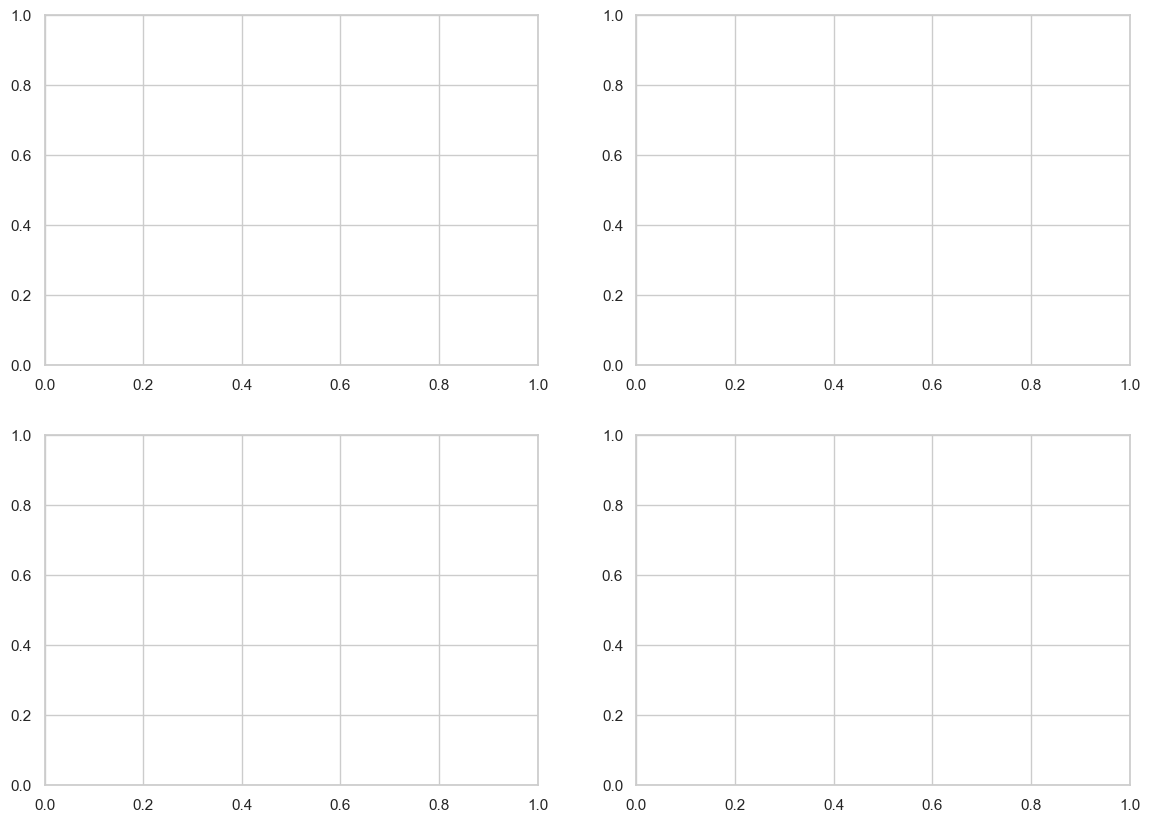

In [16]:
# --- Standardized Bar Plots for Key Metrics ---
bar_metrics = [
    'metric_predictive_mse', 
    'metric_portfolio_sharpe', 
    'metric_portfolio_var_95', 
    'metric_communication_total_MB_uploaded'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, metric in enumerate(bar_metrics):
    ax = axes[i//2, i%2]
    sns.barplot(data=summary, x='model_label', y=metric, hue=hyper_cols[0] if hyper_cols else None, ax=ax)
    ax.set_title(metric.replace('metric_', '').replace('_', ' ').title())
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    if hyper_cols:
        ax.legend(title=hyper_cols[0])
    else:
        ax.get_legend().remove()
plt.tight_layout()
plt.show()

In [15]:
# --- (Optional) Convergence/History Plots ---
# Example: Load and plot per-round history if available
# history_df = pd.read_csv('data/results/experiment_history.csv')
# plot_metric_by_param(history_df, 'validation_loss', 'round', hue='model_label', title='Validation Loss Convergence')
# plt.show()